In [1]:
## Library imports
import random
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

tf.config.list_physical_devices()

2024-12-20 12:18:20.561451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-20 12:18:21.111451: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-20 12:18:21.272195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 12:18:22.541375: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-20 12:18:28.607756: W tensorflow/comp

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Import des données

Usage de la librairie glob, qui utilise la syntaxe shell unix pour lister un très grand nombre de fichier en même temps. On utilise cela pour regrouper la donnée de tous les fichiers dans deux fichiers csv, 'data_test.csv' et 'data_train.csv'. (on ne fera donc ce processus relativement long qu'une seule fois)

In [3]:
import glob
import pandas as pd
import os

working_dir = os.listdir('./data')

if 'data_test.csv' not in working_dir:
    
    file_paths_neg = glob.glob("imdb_data/aclImdb/test/neg/*.txt")
    data_test_neg = pd.concat([pd.DataFrame({"text" : open(file, 'r').read()}, index=[0]) for file in file_paths_neg], ignore_index=True)
    
    file_paths_pos = glob.glob("imdb_data/aclImdb/test/pos/*.txt")
    data_test_pos = pd.concat([pd.DataFrame({"text" : open(file, 'r').read()}, index=[0]) for file in file_paths_pos], ignore_index=True)
    
    data_test_neg["label"] = str(0)
    
    data_test_pos["label"] = str(1)
    
    data_test = pd.concat((data_test_neg, data_test_pos)).reset_index(drop=True)
else:
    data_test = pd.read_csv("./data/data_test.csv")
    data_test = data_test.drop(columns=data_test.columns[0])
    
    
if 'data_train.csv' not in working_dir:
    
    file_paths_train_neg = glob.glob("imdb_data/aclImdb/train/neg/*.txt")
    data_train_neg = pd.concat([pd.DataFrame({"text" : open(file, 'r').read()}, index=[0]) for file in file_paths_train_neg], ignore_index=True)
    
    file_paths_train_pos = glob.glob("imdb_data/aclImdb/train/pos/*.txt")
    data_train_pos = pd.concat([pd.DataFrame({"text" : open(file, 'r').read()}, index=[0]) for file in file_paths_train_pos], ignore_index=True)
    
    data_train_neg["label"] = str(0)
    
    data_train_pos["label"] = str(1)
    
    data_train = pd.concat((data_train_neg, data_train_pos)).reset_index(drop=True)
else:
    data_train = pd.read_csv('./data/data_train.csv')
    data_train = data_train.drop(columns=data_train.columns[0])

In [4]:
print(data_train)

                                                    text  label
0      I rented I AM CURIOUS-YELLOW from my video sto...      0
1      "I Am Curious: Yellow" is a risible and preten...      0
2      If only to avoid making this type of film in t...      0
3      This film was probably inspired by Godard's Ma...      0
4      Oh, brother...after hearing about this ridicul...      0
...                                                  ...    ...
24995  A hit at the time but now better categorised a...      1
24996  I love this movie like no other. Another time ...      1
24997  This film and it's sequel Barry Mckenzie holds...      1
24998  'The Adventures Of Barry McKenzie' started lif...      1
24999  The story centers around Barry McKenzie who mu...      1

[25000 rows x 2 columns]


## TENSORFLOW

In [5]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import csv 

train_data = pd.read_csv('./data/data_train.csv').drop("Unnamed: 0", axis=1)
test_data = pd.read_csv('./data/data_test.csv').drop("Unnamed: 0", axis=1)

test_data["label"] = pd.to_numeric(test_data["label"])
train_data["label"] = pd.to_numeric(train_data["label"])

In [6]:
test_data["label"].unique()

array([0, 1])

In [7]:
test_data

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0
...,...,...
24995,Just got around to seeing Monster Man yesterda...,1
24996,I got this as part of a competition prize. I w...,1
24997,I got Monster Man in a box set of three films ...,1
24998,"Five minutes in, i started to feel how naff th...",1


In [8]:
import matplotlib.pyplot as plt 

def plot_training_analysis(history):    

    metrics = ['accuracy', 'loss']

    plt.figure(figsize=(15,5))
    
    for idx, metric in enumerate(metrics):
        plt.subplot(1,2,idx+1)
        loss = history.history[metric]
        val_loss = history.history['val_' + metric]
    
        epochs = range(len(loss))
    
        plt.plot(epochs, loss, 'b', linestyle="--",label='Training ' + metric)
        plt.plot(epochs, val_loss, 'g', label='Validation ' + metric)
        plt.title('Training and validation ' + metric)
        plt.legend()

Définition de la fonction de plot de l'analyse de l'entrainement de nos réseaux, qui nous sera utile par la sutie.

In [9]:
# Séparer les textes et les labels
x_train_raw, y_train = train_data['text'], train_data['label']
x_test_raw, y_test = test_data['text'], test_data['label']

# Tokenisation et padding
max_features = 10000  # Limite du vocabulaire
max_len = 500  # Longueur maximale des séquences

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train_raw)

x_train = tokenizer.texts_to_sequences(x_train_raw)
x_train = pad_sequences(x_train, maxlen=max_len)

x_test = tokenizer.texts_to_sequences(x_test_raw)
x_test = pad_sequences(x_test, maxlen=max_len)


## Architecture de notre modèle RNN :

Couche d'embedding : 

Cette dernière permet de représenter dans un espace latent (ici de dimension output_dim=128) les relations entre les mots de notre différent de jeu données. Ici, nous réalisons nous-mêmes cette étape. Une piste potentielle d'amélioration serait d'utiliser des embeddings pré-entraînés, comme Word2Vec, ou GloVe par exemple.

Couche "RNN" :

On utilise ici une couche récurrente disponible dans le package tensorflow. Les choix des hyperparamètres sont arbitraires, bien que nous avons testé de tous les faire varier, afin d'obtenir le meilleur résultat. On trouve qu'avec 64 dimensions cachées, le résultat est convenable. La fonction d'activation est la tangente hyperbolique, comme très souvent dans le cas d'un RNN.



Couche de dropout:

Cette dernière limite l'overfitting, en désactivant aléatoirement une proportion $p$ de neurones. Au cours de ce projet, nous avon testé des couches allant jusqu'a $p=0.8$, mais cela était bien trop aggressif, et était un obstacle trop important à l'apprentissage du modèle. A la place, nous avons préféré rester sur du $p=0.5$, en ajoutant le paramètre de régularisation $L2$ directement dans la couche RNN.

Couche de prédiction :

En sortie, on prédit soit 1, soit 0, ce qui correspond à de la classification binaire, pour laquelle seul 1 neurone suffit. Ainsi, la dimension en sortie de notre réseau est de 1.


Nous avons utilisé les mêmes **deux dernières couches** pour **tous** les réseaux de ce projet.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2 

model_RNN_checkpoint = Sequential([
    Embedding(max_features, 128),
    SimpleRNN(64, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lr = 10**(-4)                

# Compiler le modèle
model_RNN_checkpoint.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy']) 

# Définir le chemin pour sauvegarder le modèle
best_model_path = './models/best_RNN_model.weights.h5'

# Callback pour sauvegarder le meilleur modèle
checkpoint = ModelCheckpoint(filepath=best_model_path,
                             monitor='val_loss',        # Surveille la perte sur validation
                             save_best_only=True,       # Sauvegarde seulement si meilleur
                             save_weights_only=True,
                             mode='min',                # Cherche la valeur minimale de val_loss
                             verbose=1)

train_RNN = False

# Entraîner le modèle avec le callback
if train_RNN:
    history_rnn_checkpoint = model_RNN_checkpoint.fit(x_train, y_train,
                                epochs=10,
                                batch_size=32,
                                validation_split=0.2,
                                callbacks=[checkpoint])
    
    model_RNN_checkpoint.save_weights(best_model_path)
else:
    model_RNN_checkpoint.build(input_shape=(None, max_len))
    
    model_RNN_checkpoint.load_weights(best_model_path)

test_loss, test_accuracy = model_RNN_checkpoint.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

2024-12-20 12:18:51.851911: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10250 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1
/home/richaume/.conda/envs/tensorflow/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1734693535.420341   23393 service.cc:146] XLA service 0x7279b80520e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734693535.420386   23393 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-12-20 12:18:55.574321: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set 

  6/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.8296 - loss: 0.4399

I0000 00:00:1734693536.663535   23393 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.8637 - loss: 0.3925
Test Accuracy: 0.8537999987602234


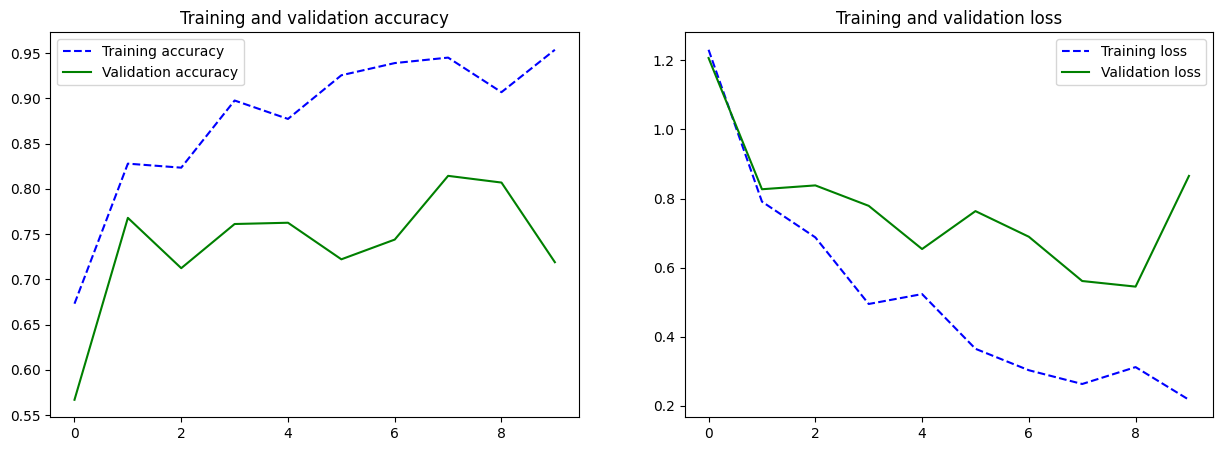

In [38]:
plot_training_analysis(history_rnn_checkpoint)

Choix des hyper-paramètres :

Batch size : 

- Un batch size de 32 semble optimal.

Learning rate :

- L'entraînement du modèle semble assez aléatoire, avec de gros sauts en loss et en accuracy... On chosit donc de baisser le learning rate en conséquence. 10-3 -> 10-4

Nombre d'epochs :

- Avec 10 epochs, on est déjà en overfitting. Plus d'epochs parait inutile dans ce cas. 

Regularization weights :

- On rajoute ce paramètre afin de réduire drastiquement l'overfitting. Un lambda = 0.01 semble donner de bons résultats, on gardera donc ce dernier pour la suite 

Remarque :

On est sûrement en face d'un problème d'exploding gradients. L'entraînement est quelque peu erratique, et la précision/loss de validation fait des sauts au cours de l'entraînement. Au final, la précision obtenue est plutôt bonne, mais on aurait aussi bien pu tomber sur une epoch malchanceuse, gâchant toute une phase d'entraînement. Ainsi, on a mis en place un checkpoint, pour revenir au meilleur modèle au cours de l'entraînement.

On choisit de sauvegarder le modèle ayant la plus faible validation loss, car la validation loss mesure directement la capacité du modèle à généraliser aux données non vues, en tenant compte non seulement des prédictions correctes, mais aussi de leur confiance. Cela permet d'éviter les modèles trop "sûrs d'eux" qui pourraient sur-apprendre les données d'entraînement. C’est le choix par défaut dans la majorité des cas.

Le checkpoint nous permet de ne garder que le meilleur modèle. Ici, on évite au modèle de passer par la phase de sur-apprentissage, qui est plus destructive qu'autre chose pour notre modèle.

## Modèle "MLP" :

Notre modèle est un simple multi layer perceptron, avec un seul neurone en sortie, pour de la classification binaire. 

Le point important de ce réseau, qui le diffère des autres, est le fait que les MLP ne peuvent **pas** directement traiter des données **séquentielles**, là ou des réseaux comme RNN, LSTM ou GRU ont été mis au point pour cela. Ainsi, on vectorise les données par **tfidf** avant de les passer en entrée de notre réseau. 

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2


tfidf = TfidfVectorizer(max_features=max_features)
x_train_tfidf = tfidf.fit_transform(x_train_raw).toarray()
x_test_tfidf = tfidf.transform(x_test_raw).toarray()

model_MLP = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

mlp_weights_path = './models/MLP.weights.h5'

              


checkpoint = ModelCheckpoint(filepath=mlp_weights_path,
                             monitor='val_loss',        # Surveille la perte sur validation
                             save_best_only=True,       # Sauvegarde seulement si meilleur
                             save_weights_only=True,
                             mode='min',                # Cherche la valeur minimale de val_loss
                             verbose=1)


model_MLP.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

train_MLP = True


if train_MLP:
    history_MLP = model_MLP.fit(x_train_tfidf,
                                y_train,
                                epochs=30, 
                                batch_size=32, 
                                validation_split=0.2,
                                callbacks=[checkpoint])
else:
    model_MLP.load_weights(mlp_weights_path)
    
test_loss, test_accuracy = model_MLP.evaluate(x_test_tfidf, y_test)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/30
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6242 - loss: 1.0657
Epoch 1: val_loss improved from inf to 1.01953, saving model to ./models/MLP.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6243 - loss: 1.0591 - val_accuracy: 0.1352 - val_loss: 1.0195
Epoch 2/30
607/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7406 - loss: 0.6927
Epoch 2: val_loss did not improve from 1.01953
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7416 - loss: 0.6926 - val_accuracy: 0.4050 - val_loss: 1.0500
Epoch 3/30
603/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8272 - loss: 0.6672
Epoch 3: val_loss improved from 1.01953 to 0.97041, saving model to ./models/MLP.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8274 - loss: 0.6670 - val_accuracy: 0.6016 - val_loss: 0.9704
Epoch 4/30
606/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8522 - loss: 0.6504
Epoch 4: val_loss improved from 0.97041 to 0.82687, saving model to ./models/M

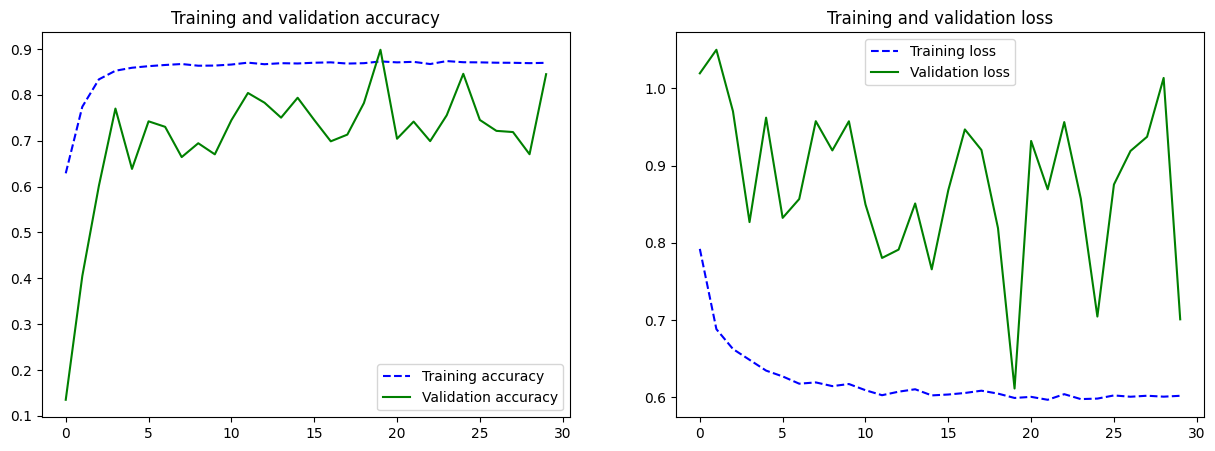

In [29]:
plot_training_analysis(history_MLP)

Les poids de régularisation sont particulièrement importants pour ce modèle, car l'overfitting y est très important sinon.

(On arrive aux 99% de précision sur training set au bout de 15 epochs)

Les résultats sont plutôt sureprenamment bons en comparaison avec ceux de notre RNN (précision de 0.84 contre 0.85, donc quasiment aussi bons).

## LSTM :

L'architecture de ce réseau est très semblable à celle de notre RNN. La seule différence est qu'à la place d'une simple couche récurrente, on a ici une couche LSTM (Long Short-Term Memory), qui est beaucoup plus complexe. 

L'objectif principal de cette couche, est de garantir le bon entraînement de notre réseau, en assurant que les gradients ne souffrent pas des deux problèmes majeurs des réseaux récurrents : les **vanishing** gradients (gradients qui s'annulent, donc "disparaissent"), et **exploding** gradients (gradients qui explosent).

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


model_LSTM = Sequential([
    Embedding(max_features, 128),
    LSTM(64, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.01), recurrent_dropout=0.5),  # Couche LSTM principale, 128->64 car résultats mauvais
    Dropout(0.5), 
    Dense(1, activation='sigmoid') 
])

lr = 10**(-4) 

# Compiler le modèle
model_LSTM.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])



best_LSTM_path = './models/best_LSTM_model.weights.h5'


LSTM_checkpoint = ModelCheckpoint(filepath=best_LSTM_path,
                             monitor='val_loss',            # Surveille la perte sur validation
                             save_best_only=True,           # On ne sauvegarde que le meilleur modèle
                             save_weights_only=True,        # On ne garde que les poids !!
                             mode='min',                    # Cherche la valeur minimale de val_loss
                             verbose=1)

train_LSTM = False


if train_LSTM:
    history_LSTM_checkpoint = model_LSTM.fit(x_train, y_train,
                                epochs=10,
                                batch_size=32,
                                validation_split=0.2,
                                callbacks=[LSTM_checkpoint])
    
    model_LSTM.save_weights(best_LSTM_path)
else:
    model_LSTM.build(input_shape=(None, max_len))
    model_LSTM.load_weights(best_LSTM_path)

/home/richaume/.conda/envs/tensorflow/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Résultat sans couches de dropout récurrentes :

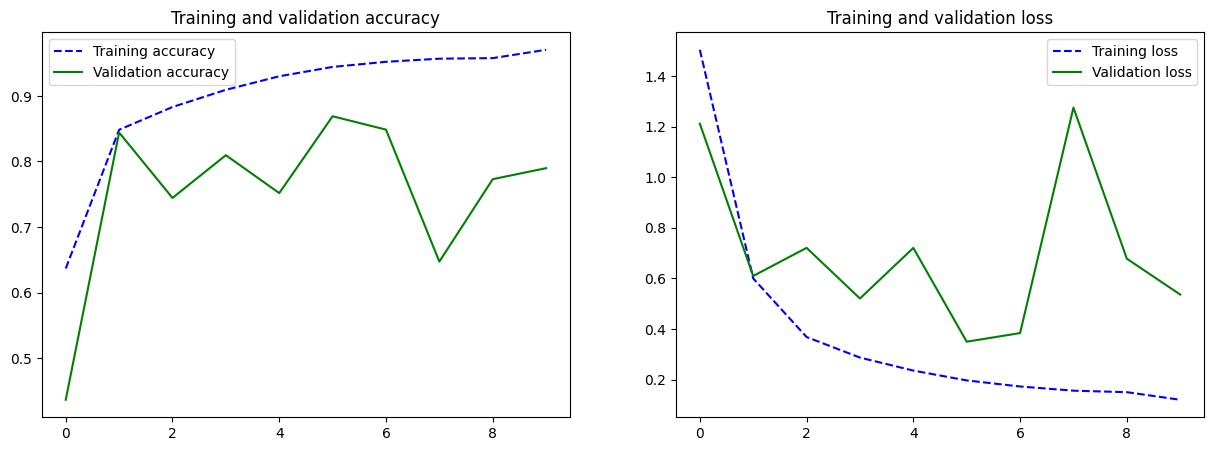

In [15]:
#plot_training_analysis(history_LSTM_checkpoint)

# SANS Couches de dropout récurrentes : 

Bien que les résultats soient plutôt bons (précision sur test set de 0.84), mon modèle est très fortement overfitté. Je rajoute des couches de dropout récurrentes dans le modèle de LSTM directement. Néanmois, cela ralentit énormément l'entraînement du modèle.

## Résulats avec couches de dropout récurrentes : 

In [34]:
# Évaluer le modèle
test_loss, test_accuracy = model_LSTM.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 135s 172ms/step - accuracy: 0.8497 - loss: 0.3636
Test Accuracy: 0.8428800106048584


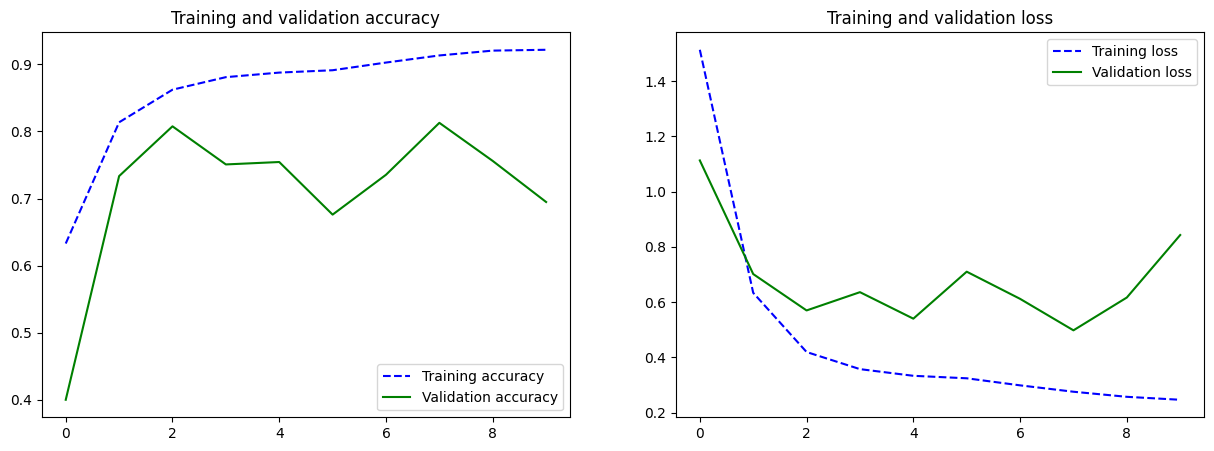

In [26]:
plot_training_analysis(history_LSTM_checkpoint)

# AVEC couches de dropout récurrentes :  

Les résultats sont plutôt décevants, compte tenu du temps d'entraînement très long pour ce modèle. (même précision que précédemment, et overfit toujours très présent) 

Je pense que rajouter des couches de dropout récurrent n'est pas nécessaire pour l'entraînement de ce modèle.

## GRU : 

Le modèle GRU (Gated Recurrent Unit) est une adaptation du modèle LSTM, qui simplifie son architecture. Les paramètres choisis sont les mêmes, et l'architecture globale reste la même.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Définir le modèle GRU
model_GRU = Sequential([
    Embedding(max_features, 128),  # Vecteurs d'embedding
    GRU(128, activation='tanh', return_sequences=False),  # Couche GRU principale
    Dropout(0.5),  # Réduction du surapprentissage
    Dense(1, activation='sigmoid')  # Couche de sortie
])

lr = 1e-4

# Compiler le modèle
model_GRU.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])


best_GRU_path = './models/best_GRU_model.weights.h5'

# Callback pour sauvegarder le meilleur modèle
GRU_checkpoint = ModelCheckpoint(filepath=best_GRU_path,
                             monitor='val_loss',        # Surveille la perte sur validation
                             save_best_only=True,       # Sauvegarde seulement si meilleur
                             save_weights_only=True,       # Sauvegarde seulement si meilleur
                             mode='min',                # on garde la meilleure (donc la plus petite) loss
                             verbose=1)

train_GRU = False

# Entraîner le modèle avec le callback
if train_GRU:
    history_GRU_checkpoint = model_GRU.fit(x_train, y_train,
                                epochs=10,
                                batch_size=32,
                                validation_split=0.2,
                                callbacks=[GRU_checkpoint])
else:
    model_GRU.build(input_shape=(None, max_len))
    # Charger les meilleurs poids sauvegardés
    model_GRU.load_weights(best_GRU_path)

# Évaluer le modèle
test_loss, test_accuracy = model_GRU.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8498 - loss: 0.3145
Test Accuracy: 0.8445199728012085


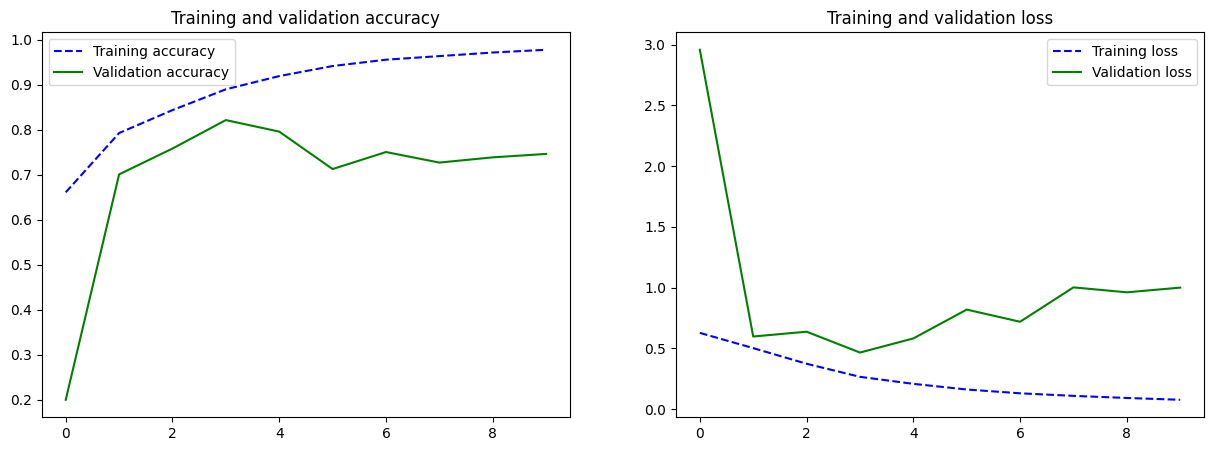

In [52]:
plot_training_analysis(history_GRU_checkpoint)

On obtient un overfitting assez rapidement, vers le 4e epoch. Comme pour LSTM, il faudrait peut-être essayer de rajouter du dropout récurrent au sein de la couche GRU. Cependant, par manque de temps, et comme nous considérons déjà nos résultats comme satisfaisants, nous ne réaliserons pas cette optimisation ici.

Plus simplement, on pourrait aussi simplement considérer rajouter des poids de régularisation au sein de la couche GRU.

## CNN : 

Les CNNs (convolutional neural network) sont habituellements utilisés pour traiter des images. Cependant, on peut espérer que les CNNs permettent de détecter des motifs au sein de notre jeu de données.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint


max_features = 10000
max_len = 500


model_CNN = Sequential([
    Embedding(max_features, 128),  
    Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01)), 
    MaxPooling1D(5),
    Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling1D(5),
    GlobalMaxPooling1D(), 
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),      
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

lr = 1e-4


model_CNN.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


best_CNN_path = './models/best_CNN_model.weights.h5'


CNN_checkpoint = ModelCheckpoint(filepath=best_CNN_path,
                                 monitor='val_loss',  # Surveille la validation accuracy
                                 save_best_only=True,     # Sauvegarde seulement si meilleur
                                 save_weights_only=True,
                                 mode='min', 
                                 verbose=1)

train_CNN = False


if train_CNN:
    history_CNN_checkpoint = model_CNN.fit(x_train, y_train,
                                           epochs=15,
                                           batch_size=16,
                                           validation_split=0.2,
                                           callbacks=[CNN_checkpoint])
else:
    model_CNN.build(input_shape=(None, max_len))
    # On charge les meilleurs poids sauvegardés
    model_CNN.load_weights(best_CNN_path)

test_loss, test_accuracy = model_CNN.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


/home/richaume/.conda/envs/tensorflow/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8415 - loss: 0.4505
Test Accuracy: 0.8404800295829773


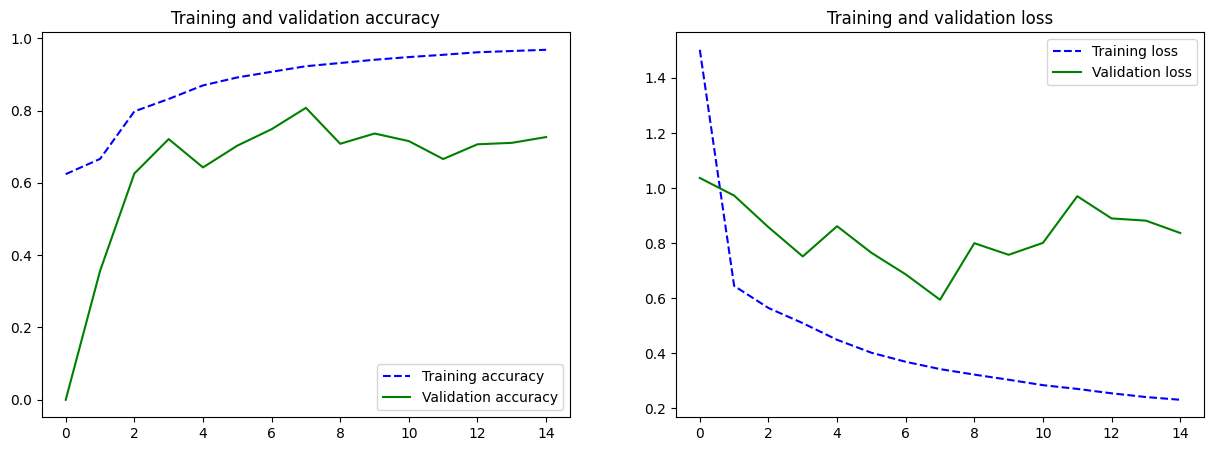

In [39]:
plot_training_analysis(history_CNN_checkpoint)

## Comparaison des modèles

Generating confusion matrix for RNN...
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step


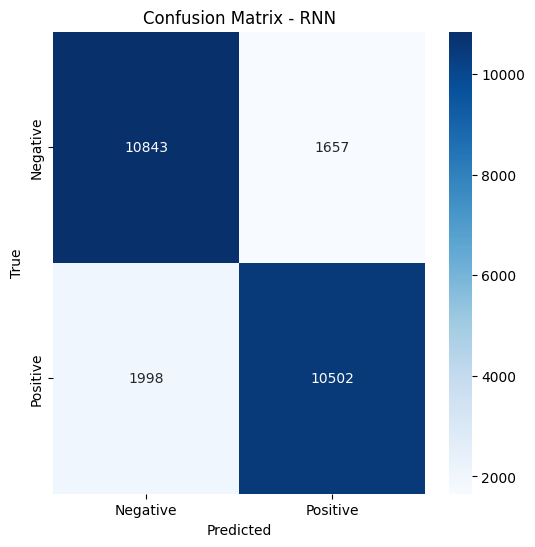

Test Accuracy for RNN: 0.8538
Generating confusion matrix for MLP...
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


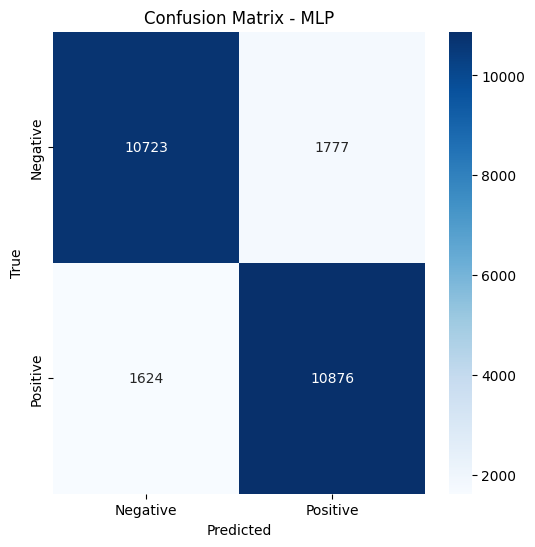

Test Accuracy for MLP: 0.8640
Generating confusion matrix for LSTM...
782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 186ms/step


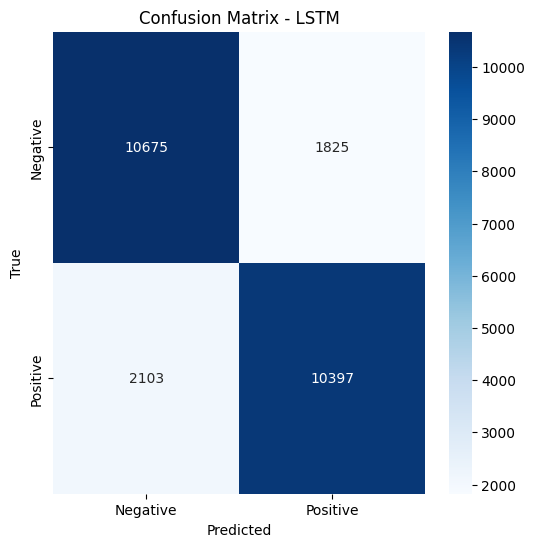

Test Accuracy for LSTM: 0.8429
Generating confusion matrix for GRU...
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step


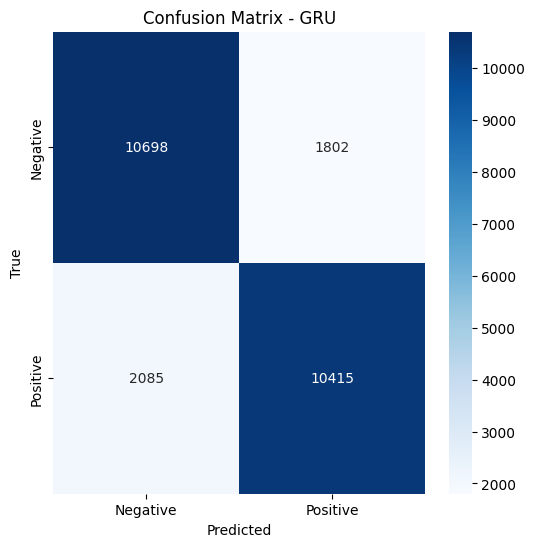

Test Accuracy for GRU: 0.8445
Generating confusion matrix for CNN...
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


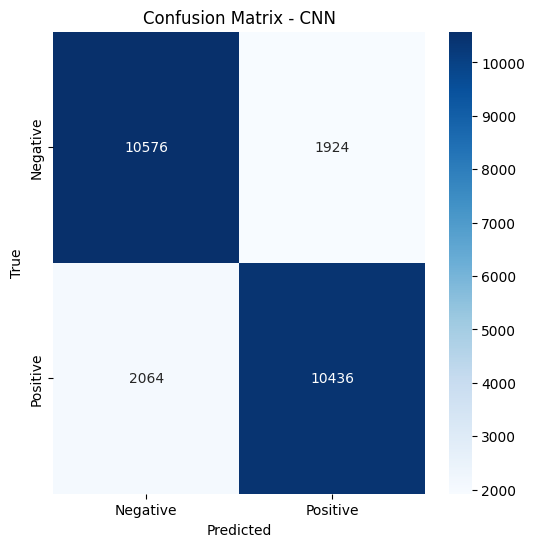

Test Accuracy for CNN: 0.8405


In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

x_test_tfidf = tfidf.transform(x_test_raw).toarray()

def plot_confusion_matrix(model, x_test, y_test, model_name):
    y_pred = model.predict(x_test)
    y_pred = (y_pred > 0.5).astype(int)
    
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy for {model_name}: {accuracy:.4f}")

models = {
    "RNN": model_RNN_checkpoint,
    "MLP": model_MLP,
    "LSTM": model_LSTM,
    "GRU": model_GRU,
    "CNN": model_CNN,
}

for model_name, model in models.items():
    print(f"Generating confusion matrix for {model_name}...")
    
    if model_name == "MLP":
        plot_confusion_matrix(model, x_test_tfidf, y_test, model_name)
    else:
        plot_confusion_matrix(model, x_test, y_test, model_name)


Tous mes modèles atteignent plus ou moins une précision similaire, mais quelques points sont importants à noter :

- Le modèle LSTM a mis le plus longtemps à entraîner, de très loin (~ 45min par entraînement) , suivi du GRU (~ 20 min par entraînement), et les trois restants furent bien plus rapides (~ 5-10 min)
- Les hyperparamètres pourraient être mieux optimisés pour la majorité des modèles, mais le temps passé sur chacun des modèles à été relativement équivalent.
- Enfin, on trouve que le meilleur modèle est le multi-layer perceptron. C'est une conclusion assez sureprenante, mais la précision de tous les modèles est tout de même très comparable.
- Le LSTM est décevant, peut-être que la tâche est trop "simple" pour un modèle si compliqué ?

## Décision par vote de la majorité 

Generating predictions from RNN...
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step
Generating predictions from MLP...
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Generating predictions from LSTM...
782/782 ━━━━━━━━━━━━━━━━━━━━ 129s 165ms/step
Generating predictions from GRU...
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step
Generating predictions from CNN...
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Shape of predictions array: (5, 25000)


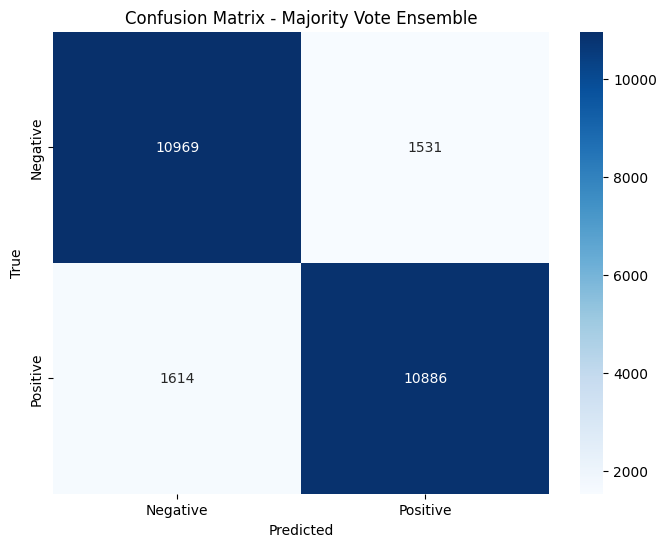

Ensemble Model Accuracy: 0.8742


In [30]:
import numpy as np
from sklearn.metrics import accuracy_score

models = {
    "RNN": model_RNN_checkpoint,
    "MLP": model_MLP,
    "LSTM": model_LSTM,
    "GRU": model_GRU,
    "CNN": model_CNN,
}

predictions = []

for model_name, model in models.items():
    print(f"Generating predictions from {model_name}...") 
    if model_name == 'MLP':
        preds = model.predict(x_test_tfidf)
    else:    
        preds = model.predict(x_test)
    preds = (preds > 0.5).astype(int)
    predictions.append(preds)

predictions = np.array(predictions).squeeze()
print("Shape of predictions array:", predictions.shape)

final_predictions = np.round(np.mean(predictions, axis=0)).astype(int)

cm = confusion_matrix(y_test, final_predictions)

# Step 4: Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix - Majority Vote Ensemble")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

ensemble_accuracy = accuracy_score(y_test, final_predictions)
print(f"Ensemble Model Accuracy: {ensemble_accuracy}")

On obtient une précision de 0.87 ! C'est donc notre meilleur modèle.

In [31]:
# Step 4: Evaluate individual models and compare
results = {}
for model_name, model in models.items():
    if model_name=='MLP':
        preds = model.predict(x_test_tfidf)
    else:
        preds = model.predict(x_test)
    preds = (preds > 0.5).astype(int)
    accuracy = accuracy_score(y_test, preds)
    results[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy}")


results["Ensemble"] = ensemble_accuracy

# On print les précisions :
print("\nComparison of Model Accuracies:")
for model_name, acc in results.items():
    print(f"{model_name}: {acc}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step
RNN Accuracy: 0.8538
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
MLP Accuracy: 0.86396
782/782 ━━━━━━━━━━━━━━━━━━━━ 133s 170ms/step
LSTM Accuracy: 0.84288
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step
GRU Accuracy: 0.84452
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN Accuracy: 0.84048

Comparison of Model Accuracies:
RNN: 0.8538
MLP: 0.86396
LSTM: 0.84288
GRU: 0.84452
CNN: 0.84048
Ensemble: 0.8742
